In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, confusion_matrix,  plot_roc_curve, roc_curve, auc

## Import Data

### Train Data

In [2]:
from google.colab import files
import io

upload_train = files.upload()
train = pd.read_csv(io.BytesIO(upload_train['train_weather_FE.csv']))
#train = pd.read_csv('../Data/train_modeling.csv')

Saving train_weather_FE.csv to train_weather_FE.csv


In [3]:
train.head()

,Date,Latitude,Longitude,WnvPresent,week_of_year,dist_to_stat_1,dist_to_stat_2,infection_rate,"('high_rate',)","('north_high',)","('north_low',)","('south_high',)","('south_low',)",Heat,Cool,Depart,Sunset,Sunrise,DarkHours,Tavg_Rol7,DewPoint_Rol7,WetBulb_Rol7,RelHumidity_Rol7,AvgSpeed_Rol7
0,2007-05-29,41.95469,-87.800991,0,22,0.138026,0.17566,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.5,10,19.283333,4.350000,9.066667,70.357143,55.857143,61.785714,0.644578,7.864286
1,2007-05-29,41.95469,-87.800991,0,22,0.138026,0.17566,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.5,10,19.283333,4.350000,9.066667,70.357143,55.857143,61.785714,0.644578,7.864286
2,2007-06-05,41.95469,-87.800991,0,23,0.138026,0.17566,0.0,0.0,0.0,0.0,1.0,0.0,8.5,0.0,-9,19.383333,4.283333,8.900000,68.142857,55.714286,61.000000,0.685041,11.214286
3,2007-06-05,41.95469,-87.800991,0,23,0.138026,0.17566,0.0,0.0,0.0,0.0,1.0,0.0,8.5,0.0,-9,19.383333,4.283333,8.900000,68.142857,55.714286,61.000000,0.685041,11.214286
4,2007-06-05,41.95469,-87.800991,0,23,0.138026,0.17566,0.0,0.0,0.0,0.0,1.0,0.0,8.5,0.0,-9,19.383333,4.283333,8.900000,68.142857,55.714286,61.000000,0.685041,11.214286


In [4]:
train.shape

(8475, 24)

In [5]:
train.set_index('Date', inplace=True)

In [6]:
train['WnvPresent'].value_counts(normalize=True)

0    0.946077
1    0.053923
Name: WnvPresent, dtype: float64

### Test Data

In [7]:
upload_test = files.upload()
test = pd.read_csv(io.BytesIO(upload_test['test_weather_FE.csv']))
#test = pd.read_csv('../Data/test_modeling.csv')

Saving test_weather_FE.csv to test_weather_FE.csv


In [8]:
test.head()

,Date,Id,Latitude,Longitude,week_of_year,dist_to_stat_1,dist_to_stat_2,infection_rate,"('high_rate',)","('north_high',)","('north_low',)","('south_high',)","('south_low',)",Heat,Cool,Depart,Sunset,Sunrise,DarkHours,Tavg_Rol7,DewPoint_Rol7,WetBulb_Rol7,RelHumidity_Rol7,AvgSpeed_Rol7
0,2008-06-11,1,41.95469,-87.800991,24,0.138026,0.17566,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,7,19.433333,4.266667,8.833333,74.071429,60.285714,65.642857,0.678617,10.771429
1,2008-06-11,2,41.95469,-87.800991,24,0.138026,0.17566,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,7,19.433333,4.266667,8.833333,74.071429,60.285714,65.642857,0.678617,10.771429
2,2008-06-11,3,41.95469,-87.800991,24,0.138026,0.17566,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,7,19.433333,4.266667,8.833333,74.071429,60.285714,65.642857,0.678617,10.771429
3,2008-06-11,4,41.95469,-87.800991,24,0.138026,0.17566,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,7,19.433333,4.266667,8.833333,74.071429,60.285714,65.642857,0.678617,10.771429
4,2008-06-11,5,41.95469,-87.800991,24,0.138026,0.17566,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,7,19.433333,4.266667,8.833333,74.071429,60.285714,65.642857,0.678617,10.771429


In [9]:
test.shape

(116293, 24)

In [10]:
test.set_index('Date', inplace=True)

## Declaring Features & Target Variable

In [12]:
X = train.drop(columns=['WnvPresent'])
y = train['WnvPresent']

In [13]:
print(X.shape, y.shape)

(8475, 22) (8475,)


## Train/Test Split 

We will first split the train data into train and validation dataset. These subsets of data will help in unbiased evaluation of our models.

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y,
                                                  stratify=y, 
                                                  random_state=42)

In [15]:
# checking the shape of both train and val dataset
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(6356, 22) (2119, 22) (6356,) (2119,)


In [16]:
X.columns

Index(['Latitude', 'Longitude', 'week_of_year', 'dist_to_stat_1',
       'dist_to_stat_2', 'infection_rate', '('high_rate',)', '('north_high',)',
       '('north_low',)', '('south_high',)', '('south_low',)', 'Heat', 'Cool',
       'Depart', 'Sunset', 'Sunrise', 'DarkHours', 'Tavg_Rol7',
       'DewPoint_Rol7', 'WetBulb_Rol7', 'RelHumidity_Rol7', 'AvgSpeed_Rol7'],
      dtype='object')

## Preprocessing

We will perform the following preprocessing steps:
- Scaling : StandardScaler is used for scaling the data.
- Smoting : As the target classes are imbalanced, we will use SMOTE which will help us synthesize the minor class instances from the existing minor instances. 

In [17]:
# scale features

ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [18]:
# using smote

sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_sample(X_train_sc, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [20]:
# checking the number of rows & columsn again in train after smoting
print(X_train_sm.shape, y_train_sm.shape)

(12026, 22) (12026,)


After smoting we now have 12026 rows in instead of the initial 8475 rows.

## Modelling

### Model Selection

Here we will run different models and will tune the hyperparameters to further improve the model. In determining the metrics to evaluate the model, we first look at the types of prediction error we could get - Type 1 error and Type 2 error.

False Positive Rate(FPR) is the fraction of false alerts based on model predictions which is when model predicting WNV present when it actually is not. From goverment's perspective, should there be infact not a WNV present and spraying efforts were made, it would be inefficient use of resources. And if people were made alarmed that their living area indicated presence of WNV, they may purchase mosquito repellents when they don't actually need to.

False Negative Rate(FNR) is the fraction of missed detection based on model predictions which is when model predicting that WNV is not present when it actually is.This might result in the residents not finding the need to buy mosquito repellents or any precautions which might result in an outbreak resulting in high healthcare costs due to this.

From the above two types of error, Type 2 is more disastrous than Type 1 error from cost basis as well as from the value of human life. Therefore our model should reduce the False positives as much as possible.

### Scoring Metrics

The precision-recall trade-off shows how to strike a balance between false positive and false negative rates. Precision measures how accurate the model is at estimating positive labels (in this case, the existence of WNV) and is a reasonable criterion to use when the cost of a false positive is greater than the cost of a false negative.

Recall calculates the percentage of actual positives a model correctly identified (ie. true positives) and is a good evaluation metric when the cost of false negative is higher than that of false positives, which is in our case.

Although recall is more relevant in our case than precision, we cannot disregard precision entirely due to excessive government spending on false positive events. Thus recall is more important than precision but not negligible.

We assess our model based on ROC-AUC curve which visualises the trade off between the True-Positive Rate(TPR) and False-Positive Rate(FPR). The better the model, the higher the TPR and the lower the FPR. AUC score of 1 indicates perfect classification, and we try to get a score closer to 1.

In [21]:
# defining a common function that we will use for modelling

def model_builder(model, params):
    
    # Declaring model metrics that we will return at the end of the function
    metrics = {}

    # Initialize gridsearch for model based on params passed
    gs = GridSearchCV(model, param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1)

    # Fit the model
    gs.fit(X_train_sm, y_train_sm)

    # Best parameters
    best_params = gs.best_params_

    # Best model
    best_model = gs.best_estimator_

    # Fit the best model
    best_model.fit(X_train_sm, y_train_sm)

    # Predic validation set
    predictions = best_model.predict(X_val_sc)

    # Calculating related metrics
    train_pred_prob = best_model.predict_proba(X_train_sm)[:,1]
    val_pred_prob = best_model.predict_proba(X_val_sc)[:,1]
    roc_auc_train = roc_auc_score(y_train_sm, train_pred_prob)
    roc_auc_val = roc_auc_score(y_val, val_pred_prob)
    tn, fp, fn, tp = confusion_matrix(y_val, predictions).ravel()
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    accuracy = (tn + tp)/(tn + tp + fn + fp)
  
    metrics['roc_auc_train'] = roc_auc_train
    metrics['roc_auc_val'] = roc_auc_val
    metrics['accuracy'] = accuracy
    metrics['sensitivity'] = sensitivity
    metrics['specificity'] = specificity
    metrics['FalsePos'] = fp
    metrics['TruePos'] = tp
    metrics['FalseNeg'] = fn
    metrics['TrueNeg'] = tn
  
    # Returning best params, model and the metrics
    return (best_params, best_model, metrics)

### Logistic Regression

In [37]:
# declare grid search parameters

lr_params = {'solver':['saga'], 
             'penalty':['l1','l2','elasticnet'], 
             'C':[1, 10, 20],
             'max_iter':[5000],
             'random_state':[42]
            }

# Initial the model
lr_model = LogisticRegression()

best_params_lr, best_model_lr, metrics_lr = model_builder(lr_model, lr_params)

print(best_params_lr)
print(metrics_lr)

{'C': 10, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
{'roc_auc_train': 0.8321184691884806, 'roc_auc_val': 0.8263026643916525, 'accuracy': 0.7083529966965549, 'sensitivity': 0.7543859649122807, 'specificity': 0.7057356608478803, 'FalsePos': 590, 'TruePos': 86, 'FalseNeg': 28, 'TrueNeg': 1415}


### Random Forest 

In [23]:
# declare grid search parameters
rf_params = {'n_estimators':[100, 150, 190], 
             'class_weight': ['balanced'],
             'max_depth':[4, 5, 6],
             'random_state':[42]}

# Initialize the model
rf_model = RandomForestClassifier()

best_params_rf, best_model_rf, metrics_rf = model_builder(rf_model, rf_params)

print(best_params_rf)
print(metrics_rf)

{'class_weight': 'balanced', 'max_depth': 6, 'n_estimators': 100, 'random_state': 42}
{'roc_auc_train': 0.9285297620995189, 'roc_auc_val': 0.8522268889180558, 'accuracy': 0.7442189712128362, 'sensitivity': 0.8333333333333334, 'specificity': 0.7391521197007481, 'FalsePos': 523, 'TruePos': 95, 'FalseNeg': 19, 'TrueNeg': 1482}


### Ada Boost

In [29]:
# declare grid search parameters
ada_params = {'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [100, 150, 200],
              'random_state': [42]}

# Initialize the model
ada_model = AdaBoostClassifier()

best_params_ada, best_model_ada, metrics_ada = model_builder(ada_model, ada_params)

print(best_params_ada)
print(metrics_ada)

{'learning_rate': 0.3, 'n_estimators': 200, 'random_state': 42}
{'roc_auc_train': 0.926052785072445, 'roc_auc_val': 0.8414599466246664, 'accuracy': 0.7824445493157149, 'sensitivity': 0.7192982456140351, 'specificity': 0.7860349127182045, 'FalsePos': 429, 'TruePos': 82, 'FalseNeg': 32, 'TrueNeg': 1576}


### Gradient Boost

In [30]:
# declare grid search parameters
gb_params = {'learning_rate': [0.2, 0.3, 0.5],
             'max_depth': [3, 4, 5],
             'n_estimators': [100, 150, 200, 300],
             'random_state': [42]}

# Initialize the model
gb_model = GradientBoostingClassifier()

best_params_gb, best_model_gb, metrics_gb = model_builder(gb_model, gb_params)

print(best_params_gb)
print(metrics_gb)

{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 300, 'random_state': 42}
{'roc_auc_train': 0.9990870852495461, 'roc_auc_val': 0.8464190401190008, 'accuracy': 0.9301557338367155, 'sensitivity': 0.23684210526315788, 'specificity': 0.9695760598503741, 'FalsePos': 61, 'TruePos': 27, 'FalseNeg': 87, 'TrueNeg': 1944}


### Extra Tress

In [31]:
# declare grid search parameters
et_params = {'n_estimators': [50, 100,150,200],
             'max_depth': [4, 5, 6],
             'max_features': ['sqrt', 'log2'],
             'random_state': [42]
            }

# Initiatize the model
et_model = ExtraTreesClassifier()

best_params_et, best_model_et, metrics_et = model_builder(et_model, et_params)

print(best_params_et)
print(metrics_et)

{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 150, 'random_state': 42}
{'roc_auc_train': 0.8972989505608295, 'roc_auc_val': 0.8526993918711991, 'accuracy': 0.7272298253893346, 'sensitivity': 0.8508771929824561, 'specificity': 0.7201995012468828, 'FalsePos': 561, 'TruePos': 97, 'FalseNeg': 17, 'TrueNeg': 1444}


### Comparing the models

In [38]:
scores = [['Logistic Regression', metrics_lr['roc_auc_train'], metrics_lr['roc_auc_val'], 
           metrics_lr['sensitivity'], metrics_lr['specificity'], metrics_lr['accuracy'], '0.71408'],
          ['Random Forest', metrics_rf['roc_auc_train'], metrics_rf['roc_auc_val'],  
           metrics_rf['sensitivity'], metrics_rf['specificity'], metrics_rf['accuracy'], '0.73149'],
          ['Ada Boost', metrics_ada['roc_auc_train'], metrics_ada['roc_auc_val'], 
           metrics_ada['sensitivity'], metrics_ada['specificity'], metrics_ada['accuracy'], '0.74243'],
          ['Extra Trees', metrics_et['roc_auc_train'], metrics_et['roc_auc_val'], 
           metrics_et['sensitivity'], metrics_et['specificity'], metrics_et['accuracy'], '0.74114'],
          ['Gradient Boost', metrics_gb['roc_auc_train'], metrics_gb['roc_auc_val'], 
           metrics_gb['sensitivity'], metrics_gb['specificity'], metrics_gb['accuracy'], '0.71217']]
print (tabulate(scores, headers=["", "Roc Auc Train", "Roc Auc Validation", "Accuracy", 'Sensitivity', 'Specificity', 'Test Roc Auc Score']))

                       Roc Auc Train    Roc Auc Validation    Accuracy    Sensitivity    Specificity    Test Roc Auc Score
-------------------  ---------------  --------------------  ----------  -------------  -------------  --------------------
Logistic Regression         0.832118              0.826303    0.754386       0.705736       0.708353               0.71408
Random Forest               0.92853               0.852227    0.833333       0.739152       0.744219               0.73149
Ada Boost                   0.926053              0.84146     0.719298       0.786035       0.782445               0.74243
Extra Trees                 0.897299              0.852699    0.850877       0.7202         0.72723                0.74114
Gradient Boost              0.999087              0.846419    0.236842       0.969576       0.930156               0.71217


- If we compare the models, Gradient Boost have the highest roc auc but it scores very poorly for accuracy. Moreover, the train and test roc auc score indicates overfitting.
- Other models does seem to perform efficiently in terms of overfitting. 
- Random Forest and Ada Boost perform pretty well for roc auc scores in comparison to Logistic Regression and Extra Trees. 
- The sensitivity (True Positive) of Ada Boost is higher than Random Forest, however we would like to analyze in more detail by plotting ROC curve.

<Figure size 1440x1080 with 0 Axes>

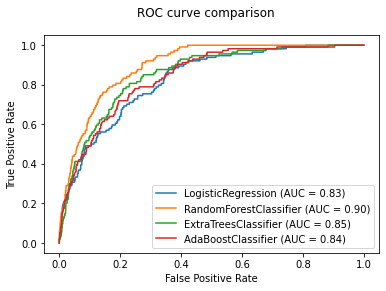

In [33]:
plt.figure(figsize=(20,15))
lr_disp = plot_roc_curve(best_model_lr, X_val_sc, y_val)
rf_disp = plot_roc_curve(best_model_rf, X_val_sc, y_val, ax=lr_disp.ax_)
et_disp = plot_roc_curve(best_model_et, X_val_sc, y_val, ax=lr_disp.ax_)
ada_disp = plot_roc_curve(best_model_ada, X_val_sc, y_val, ax=lr_disp.ax_)
ada_disp.figure_.suptitle("ROC curve comparison");

From the above ROC we can clearly see that Random Forest performs the best out of all the other models. As mentioned previously, the higher the AUC, the model is able to perform more efficiently in classifying the data.

Aside from comparing the AUC which determines how well our model separates the true positives and true negatives, we would further like to compare our models based on Precision and Sensitivity(Recall).

In [35]:
def plot_sensitivity_precision(model, label, ax):
  conf_matrix = []

  for threshold in np.linspace(0, .5, 25):
    y_preds = (model.predict_proba(X_val_sc)[:, 1] > threshold).astype('float')
    tn, fp, fn, tp = confusion_matrix(y_val, y_preds).ravel()
    sensitivity = tp/(tp + fn)
    precision = tp/(tp + fp)
    conf_matrix.append([threshold, sensitivity, precision])
                   
    matrix = pd.DataFrame(conf_matrix, columns=['threshold', 'sensitivity', 'precision'])    

  #plt.plot(data=matrix, x='precision', y='sensitivity', ax=ax)
  ax.plot(matrix['precision'], matrix['sensitivity'], label=label)
  ax.set_xlabel('Precision')
  ax.set_ylabel('Sensitivity')

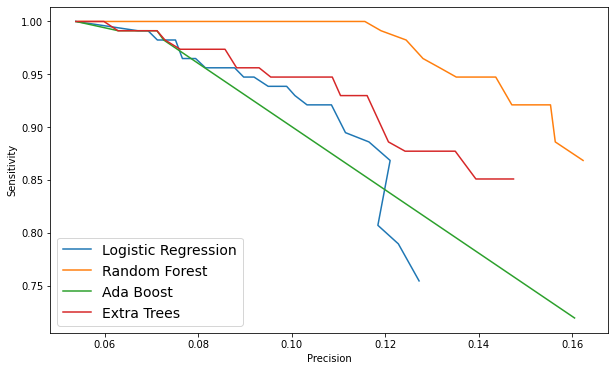

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_sensitivity_precision(best_model_lr, 'Logistic Regression', ax)
plot_sensitivity_precision(best_model_rf, 'Random Forest', ax)
plot_sensitivity_precision(best_model_ada, 'Ada Boost', ax)
plot_sensitivity_precision(best_model_et, 'Extra Trees',ax)
ax.legend(fontsize=14);

The above plot shows the trade-off between Precision and Sensitivity. High precision relates to low false positive rate and high sensitivity/recall relates to low false negetive rate.

Random forest has a quite uniform and high Precision over different rates along with maintaining high sensitivity.

Hence we can conclude that Random forest performs the best and is our chosen model for predicting the Westnile Virus.

### Feature Importance

In [39]:
# coefs / features here 
# Assuming we have random forest as our final model , need to test this
def top10_features(best_model, title):
    feature_imp = best_model.feature_importances_

    feature_imp_df = pd.DataFrame([X.columns, feature_imp])
    
    plt.figure(figsize=(10,8))
    sns.barplot(data=feature_imp_df.T.sort_values(by=1, ascending=False), y=0, x=1, orient='h', palette='coolwarm')

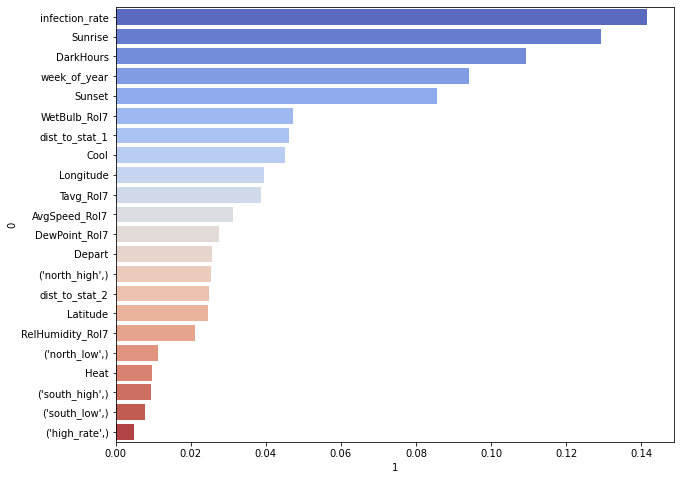

In [40]:
top10_features(best_model_rf, 'Feature Importance');

- Infection rate seems to be one of the most important feature.
- As we initially though, DarkHours turned out to be in the top features for predicting the virus. Sunrise and Sunset were also among them.
- 


### Final Predictions

In [24]:
# scaling the test data

ss = StandardScaler()
X_test = test.drop(columns=['Id'])

train_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [25]:
best_model_rf.fit(train_sc, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [26]:
# Predicting test data
predictions = best_model_rf.predict_proba(X_test_sc)[:,1]
pred_df = pd.DataFrame({'Id': test['Id'], 'WnvPresent': predictions})

In [ ]:
pred_df.head()

,Id,WnvPresent
Date,,
2008-06-11,1,0.002408
2008-06-11,2,0.002408
2008-06-11,3,0.002408
2008-06-11,4,0.002408
2008-06-11,5,0.002408


In [28]:
preds = pd.DataFrame({'PredProb': predictions, 'Week_Of_Year': X_test['week_of_year']})
preds.to_csv('predict_prob.csv', index=False)
files.download('predict_prob.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Exporting the data to a file to submit to kaggle
pred_df.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Cost and Benefit Analysis

  In 2005, a WNV outbreak in [California](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/) occured in Sacramento County with 163 human cases. About 2.28 million were spent on medical treatment and patients' productivity loss for both WNF(West Nile Fever) and WNND(West Nile Neuroinvasive Disease). 
Vector control cost approximately \\$710790, including spray procedures and overtime hours. 
The total economic impact of WNV was $2.98 million. A cost-benefit analysis indicated that only 15 cases of West Nile neuroinvasive disease would need to be prevented to make the 	emergency spray cost-effective.

  Using population-based methods to estimate the costs of WNV from the healthcare payer perspective, it is found that healthcare resource utilisation is elevated across all phases of care attributable to WNV infections and WNND syndromes.High costs of treatment underscore the importance of evaluating the cost effectiveness of WNV and other mosquito-borne disease prevention through vector control strategies (e.g., draining surface water, larviciding) and novel vaccinations to inform healthcare resource allocation in [Ontario](https://bmcinfectdis.biomedcentral.com/articles/10.1186/s12879-019-4596-9).

  A research team determined the cost of initial hospitalisation for 80 patients during a 2003 outbreak in [Colorado](https://www.sciencedaily.com/releases/2014/02/140210184713.htm). For a subset of these patients, they then calculated costs of additional related medical care and missed work incurred in the 5 years after the initial infection. To estimate the total cost of WNV disease to the nation, the research team extrapolated those costs to the total number of hospitalised cases of WNV disease reported to CDC since 1999. Those findings suggest an annual burden of $56 million in the United States.
